In [ ]:
"""Notes:
1. Add more movies/dimensions
2. Can group by genres, i.e. romance, scifi etc

https://pyro.ai/examples/gmm.html
"""

# Method 1

In [ ]:
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
import pandas as pd
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.4.1')
pyro.enable_validation(True)

In [ ]:
# The movies database
tmdb_path = os.path.join("../","data","the-movies-dataset")

ratings_dir = os.path.join(tmdb_path, "ratings.csv")
ratings_small_dir = os.path.join(tmdb_path, "ratings_small.csv")
movies_metadata_dir = os.path.join(tmdb_path, "movies_metadata.csv")
links_dir = os.path.join(tmdb_path, "links.csv")
links_small_dir = os.path.join(tmdb_path, "links_small.csv")
keywords_dir = os.path.join(tmdb_path, "keywords.csv")
credits_dir = os.path.join(tmdb_path, "credits.csv")

In [ ]:
# Ratings small
ratings_small = pd.read_csv(ratings_small_dir)
ratings_small

In [ ]:
# Movies metadata
pd.read_csv(movies_metadata_dir)

In [ ]:
# Links
pd.read_csv(links_small_dir)

In [ ]:
pd.read_csv(keywords_dir)

In [ ]:
# Pick all movies, using pivot
ratings_small_pivot = ratings_small.pivot(index='userId', columns='movieId', values='rating')
ratings_small_pivot


In [ ]:
# Pick one movie (id=31) and cluster users by ratings
ratings_small_sample = ratings_small[ratings_small['movieId']==31]
data = torch.tensor(ratings_small['rating'].values, dtype=torch.float32)

In [ ]:
# Create fake dataset with 2 columns
data = torch.tensor([[0., 1., 10., 11., 12.],[0, 1, 5, 2, 10]])
pyplot.scatter(data[0], data[1])

In [ ]:
K = 2  # Fixed number of components.

# = 1 dimension
# @config_enumerate
# def model(data):
#     # Global variables.
#     weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
#     scale = pyro.sample('scale', dist.LogNormal(0., 2.))
#     with pyro.plate('components', K):
#         locs = pyro.sample('locs', dist.Normal(0., 10.))

#     with pyro.plate('data', len(data)):
#         # Local variables.
#         # Multinomial Dirichlet
#         assignment = pyro.sample('assignment', dist.Categorical(weights))
#         pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

# > 1 dimensions
@config_enumerate      
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(2), 10.).independent(1))
        assert locs.shape == (K, 2)
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale).independent(1),
                    obs=data)

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [ ]:
locs.shape

In [ ]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [ ]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

In [ ]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

In [ ]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

# Method 2

In [3]:
# Source: https://github.com/mcdickenson/em-gaussian/blob/master/em-gaussian-pyro.py
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch

from matplotlib.patches import Ellipse
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints

In [34]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables.
    """2 clusters"""
    #weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    #scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]]]), constraint=constraints.positive)
    #locs = pyro.param('locs', torch.tensor([[1., 2.], [3., 4.]]))
    
    """3 clusters"""
    weights = pyro.param('weights', torch.FloatTensor([0.5]), constraint=constraints.unit_interval)
    scales = pyro.param('scales', torch.tensor([[[1., 0.], [0., 2.]], [[3., 0.], [0., 4.]], [[5., 0.], [0., 10.]]), constraint=constraints.positive)
    locs = pyro.param('locs', torch.tensor([[0., 5.], [5., 0.], [10., 10.]]))

    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)


@config_enumerate(default="parallel")
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables.
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={"enumerate": "sequential"})


def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise.
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var]*4), constraint=constraints.positive)

    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi


def get_samples():
    num_samples = 100

    # 2 clusters
    # note that both covariance matrices are diagonal
    mu1 = torch.tensor([0., 20.])
    sig1 = torch.tensor([[2., 0.], [0., 3.]])

    mu2 = torch.tensor([20., 0.])
    sig2 = torch.tensor([[4., 0.], [0., 1.]])
    
    # add 3rd cluster
    mu3 = torch.tensor([10., 10.])
    sig3 = torch.tensor([[5., 0.], [0., 10.]])
    

    # generate samples
    dist1 = dist.MultivariateNormal(mu1, sig1)
    samples1 = [pyro.sample('samples1', dist1) for _ in range(num_samples)]

    dist2 = dist.MultivariateNormal(mu2, sig2)
    samples2 = [pyro.sample('samples2', dist2) for _ in range(num_samples)]
    
    dist3 = dist.MultivariateNormal(mu3, sig3)
    samples3 = [pyro.sample('samples2', dist3) for _ in range(num_samples)]

    data = torch.cat((torch.stack(samples1), torch.stack(samples2), torch.stack(samples3)))
    return data


def plot(data, mus=None, sigmas=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if mus is not None:
        x = [float(m[0]) for m in mus]
        y = [float(m[1]) for m in mus]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if sigmas is not None:
        for sig_ix in range(K):
            ax = fig.gca()
            cov = np.array(sigmas[sig_ix])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                          width=lam[0]*4, height=lam[1]*4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    fig.savefig(figname)

SyntaxError: invalid syntax (<ipython-input-34-74fc61704b72>, line 12)

locs: tensor([[ 1.1000,  2.1000],
        [ 3.1000,  4.1000],
        [10.0000, 10.0000]], requires_grad=True)
scales: tensor([[[1.1052, 0.0000],
         [0.0000, 2.2103]],

        [[3.3155, 0.0000],
         [0.0000, 4.4207]],

        [[1.0000, 0.0000],
         [0.0000, 2.0000]]], grad_fn=<AddBackward0>)
weights = tensor([0.3333], grad_fn=<ClampBackward>)
assignments: tensor([0.3559, 0.3559, 0.3559, 0.3559, 0.3559, 0.3559, 0.3115, 0.3559, 0.3559,
        0.3115, 0.3559, 0.3559, 0.3559, 0.3115, 0.3559, 0.3559, 0.3559, 0.3115,
        0.3115, 0.3559, 0.3115, 0.3559, 0.3559, 0.3559, 0.3115, 0.3115, 0.3559,
        0.3559, 0.3559, 0.3115, 0.3559, 0.3559, 0.3559, 0.3115, 0.3115, 0.3559,
        0.3559, 0.3559, 0.3559, 0.3559, 0.3115, 0.3115, 0.3559, 0.3559, 0.3559,
        0.3559, 0.3559, 0.3559, 0.3559, 0.3559, 0.3559, 0.3115, 0.3115, 0.3559,
        0.3559, 0.3559, 0.3559, 0.3559, 0.3115, 0.3559, 0.3115, 0.3559, 0.3115,
        0.3559, 0.3559, 0.3115, 0.3559, 0.3559, 0.3559, 0.3115, 

locs: tensor([[ 2.5612,  3.0080],
        [ 9.4362,  8.7765],
        [10.0000, 10.0000]], requires_grad=True)
scales: tensor([[[10.1918,  0.0000],
         [ 0.0000,  9.6007]],

        [[ 6.9100,  0.0000],
         [ 0.0000, 22.3276]],

        [[ 1.0000,  0.0000],
         [ 0.0000,  2.0000]]], grad_fn=<AddBackward0>)
weights = tensor([0.3402], grad_fn=<ClampBackward>)
assignments: tensor([0.0061, 0.0065, 0.0025, 0.0301, 0.0085, 0.0169, 0.0109, 0.0119, 0.0329,
        0.0036, 0.0304, 0.0106, 0.0051, 0.0040, 0.0084, 0.0111, 0.0139, 0.0031,
        0.0035, 0.0130, 0.0037, 0.0058, 0.0277, 0.0053, 0.0049, 0.0062, 0.0265,
        0.0176, 0.0151, 0.0037, 0.0246, 0.0219, 0.0108, 0.0019, 0.0045, 0.0065,
        0.0061, 0.0031, 0.0013, 0.0144, 0.0040, 0.0046, 0.0151, 0.0280, 0.0059,
        0.0104, 0.0205, 0.0064, 0.0014, 0.0932, 0.0092, 0.0086, 0.0060, 0.0049,
        0.0012, 0.0054, 0.0047, 0.0329, 0.0038, 0.0113, 0.0038, 0.0139, 0.0096,
        0.0236, 0.0047, 0.0108, 0.0044, 0.0715, 0.00

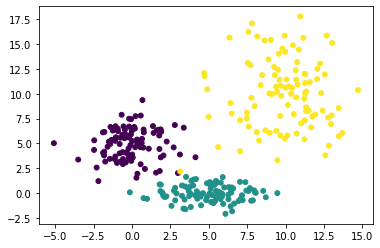

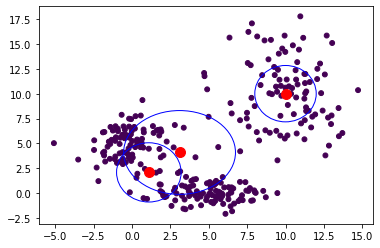

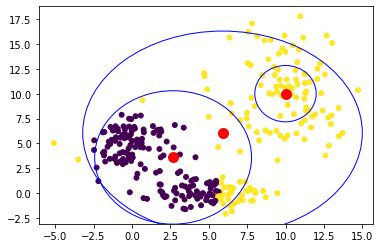

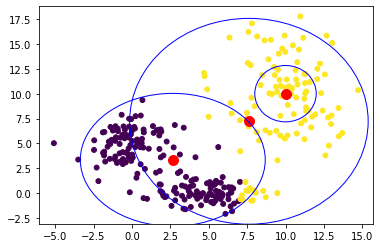

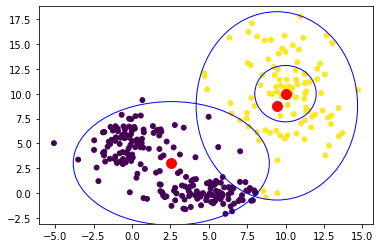

In [36]:
if __name__ == "__main__":
    pyro.enable_validation(True)
    pyro.set_rng_seed(42)

    # Create our model with a fixed number of components
    K = 3

    data = get_samples()

    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
    global_guide = config_enumerate(global_guide, 'parallel')
    _, svi = initialize(data)
    
    num_samples = 100
    true_colors = [0] * num_samples + [1] * num_samples + [2] * num_samples
    plot(data, colors=true_colors, figname='pyro_init.png')

    for i in range(151):
        svi.step(data)

        if i % 50 == 0:
            locs = pyro.param('locs')
            scales = pyro.param('scales')
            weights = pyro.param('weights')
            assignment_probs = pyro.param('assignment_probs')

            print("locs: {}".format(locs))
            print("scales: {}".format(scales))
            print('weights = {}'.format(weights))
            print('assignments: {}'.format(assignment_probs))

            # todo plot data and estimates
            assignments = np.uint8(np.round(assignment_probs.data))
            plot(data, locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))

tensor([0.3333])